In [66]:
import tensorflow as tf
import numpy as np
from tensorflow import keras 
print(tf.__version__)
print(np.__version__)

import warnings
warnings.filterwarnings("ignore")

2.6.0
1.21.4


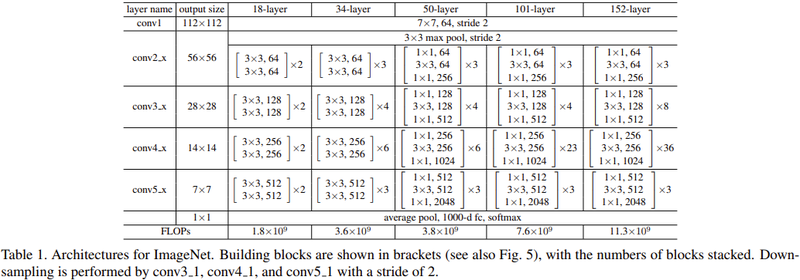

In [8]:
# tensorflow cats_vs_dogs dataset load

import tensorflow_datasets as tfds
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [21]:
print(raw_train, raw_validation, raw_test, sep='\n')

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


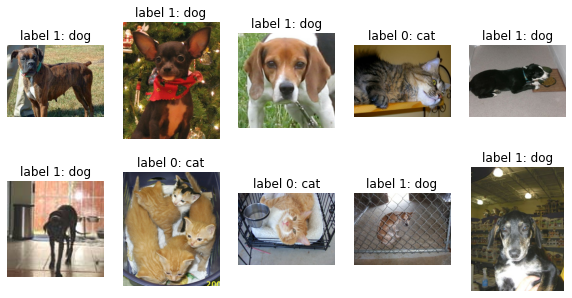

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str
# take() create new dataset instance as much as parameter
for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

data preprocess

In [45]:
img_size = 224

def format_example(image, label):
    image = tf.cast(image, tf.float32) # type cast in tensorflow
    image = (image/127.5) - 1 # modify pixel scale -1 ~ 1
    image = tf.image.resize(image, (img_size, img_size))
    return image, label


split train, valid, test set

In [46]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train, validation, test, sep='\n')

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


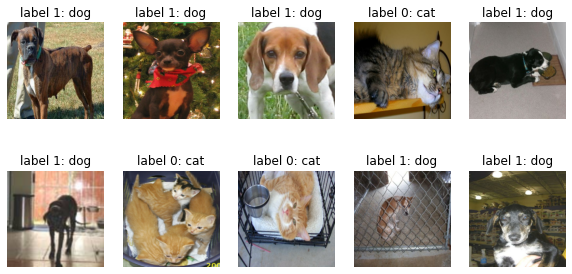

In [47]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

modeling resnet_34, resnet_50, plain_34, plain_50

In [48]:
# default(resnet_34), else is_50, else is_plain
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling X
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model
    
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False)
resnet_34.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 112, 112, 64) 832         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_238 (BatchN (None, 112, 112, 64) 256         conv2d_56[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_238[0][0]    
___________________________________________________________________________________________

In [49]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True)
resnet_50.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 112, 112, 64) 832         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_255 (BatchN (None, 112, 112, 64) 256         conv2d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_255[0][0]    
___________________________________________________________________________________________

plain model

In [50]:
plain_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_plain=True)
plain_34.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 112, 112, 64) 832         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_272 (BatchN (None, 112, 112, 64) 256         conv2d_64[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_272[0][0]    
___________________________________________________________________________________________

In [51]:
plain_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_plain=True)
plain_50.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 112, 112, 64) 832         input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_289 (BatchN (None, 112, 112, 64) 256         conv2d_68[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_289[0][0]    
___________________________________________________________________________________________

In [53]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [54]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

resnet 34 training

In [52]:
learning_rate = 0.0001

resnet_34.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [55]:
epoch = 10
history_34 = resnet_34.fit(train_batches,
                    epochs=epoch,
                    validation_data=validation_batches)

Epoch 1/10
166/582 [=======>......................] - ETA: 1:13 - loss: 2.2231 - accuracy: 0.5870

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:08 - loss: 2.0355 - accuracy: 0.5923

209/582 [=========>....................] - ETA: 1:06 - loss: 1.9834 - accuracy: 0.5943

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 1.7148 - accuracy: 0.6056

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 1.2932 - accuracy: 0.6337

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 1.2762 - accuracy: 0.6358

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 1.2623 - accuracy: 0.6368

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 1.2301 - accuracy: 0.6400

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 1.2226 - accuracy: 0.6409

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.1870 - accuracy: 0.6436

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 119s 186ms/step - loss: 1.1870 - accuracy: 0.6436 - val_loss: 0.5982 - val_accuracy: 0.7025
Epoch 2/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.6060 - accuracy: 0.7022

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.5966 - accuracy: 0.7073

209/582 [=========>....................] - ETA: 1:05 - loss: 0.5948 - accuracy: 0.7086

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 0.5833 - accuracy: 0.7139

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.5571 - accuracy: 0.7271

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.5555 - accuracy: 0.7278

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.5542 - accuracy: 0.7287

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.5503 - accuracy: 0.7302

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.5502 - accuracy: 0.7299

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.7313

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 184ms/step - loss: 0.5478 - accuracy: 0.7313 - val_loss: 2.7154 - val_accuracy: 0.7141
Epoch 3/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.4873 - accuracy: 0.7701

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.4855 - accuracy: 0.7703

209/582 [=========>....................] - ETA: 1:05 - loss: 0.4866 - accuracy: 0.7700

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.4727 - accuracy: 0.7806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.4503 - accuracy: 0.7928

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.4487 - accuracy: 0.7937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.4476 - accuracy: 0.7943

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.4448 - accuracy: 0.7961

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.4442 - accuracy: 0.7960

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.7968

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 180ms/step - loss: 0.4412 - accuracy: 0.7968 - val_loss: 0.4101 - val_accuracy: 0.8040
Epoch 4/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.3857 - accuracy: 0.8238

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:08 - loss: 0.3835 - accuracy: 0.8249

209/582 [=========>....................] - ETA: 1:06 - loss: 0.3845 - accuracy: 0.8242

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 0.3740 - accuracy: 0.8324

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.3583 - accuracy: 0.8403

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.3582 - accuracy: 0.8400

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.3573 - accuracy: 0.8406

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.3558 - accuracy: 0.8417

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.3560 - accuracy: 0.8416

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8427

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.3532 - accuracy: 0.8427 - val_loss: 1.5776 - val_accuracy: 0.7820
Epoch 5/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.3184 - accuracy: 0.8673

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.3184 - accuracy: 0.8676

209/582 [=========>....................] - ETA: 1:05 - loss: 0.3152 - accuracy: 0.8687

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.3053 - accuracy: 0.8729

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.2894 - accuracy: 0.8790

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.2889 - accuracy: 0.8791

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.2873 - accuracy: 0.8798

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.2865 - accuracy: 0.8803

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.2862 - accuracy: 0.8804

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.8814

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.2838 - accuracy: 0.8814 - val_loss: 0.9572 - val_accuracy: 0.6642
Epoch 6/10
166/582 [=======>......................] - ETA: 1:12 - loss: 0.2552 - accuracy: 0.8946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.2534 - accuracy: 0.8956

209/582 [=========>....................] - ETA: 1:05 - loss: 0.2591 - accuracy: 0.8946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.2469 - accuracy: 0.8996

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.2428 - accuracy: 0.9025

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.2426 - accuracy: 0.9026

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.2411 - accuracy: 0.9031

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.2375 - accuracy: 0.9044

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.2401 - accuracy: 0.9036

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9047

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 180ms/step - loss: 0.2375 - accuracy: 0.9047 - val_loss: 1.2950 - val_accuracy: 0.7902
Epoch 7/10
167/582 [=======>......................] - ETA: 1:13 - loss: 0.2182 - accuracy: 0.9085

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.2155 - accuracy: 0.9102

209/582 [=========>....................] - ETA: 1:05 - loss: 0.2136 - accuracy: 0.9107

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 0.2113 - accuracy: 0.9130

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.2057 - accuracy: 0.9169

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.2044 - accuracy: 0.9173

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.2035 - accuracy: 0.9175

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.2002 - accuracy: 0.9188

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.1998 - accuracy: 0.9189

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9191

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 184ms/step - loss: 0.2001 - accuracy: 0.9191 - val_loss: 0.3973 - val_accuracy: 0.8577
Epoch 8/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.1867 - accuracy: 0.9273

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.1821 - accuracy: 0.9289

209/582 [=========>....................] - ETA: 1:05 - loss: 0.1826 - accuracy: 0.9282

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 0.1781 - accuracy: 0.9298

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.1666 - accuracy: 0.9358

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.1665 - accuracy: 0.9357

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.1657 - accuracy: 0.9361

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.1656 - accuracy: 0.9362

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.1645 - accuracy: 0.9366

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9376

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 181ms/step - loss: 0.1629 - accuracy: 0.9376 - val_loss: 0.5667 - val_accuracy: 0.8650
Epoch 9/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.1459 - accuracy: 0.9422

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.1417 - accuracy: 0.9438

209/582 [=========>....................] - ETA: 1:05 - loss: 0.1393 - accuracy: 0.9451

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 0.1392 - accuracy: 0.9463

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.1366 - accuracy: 0.9481

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.1366 - accuracy: 0.9480

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.1362 - accuracy: 0.9480

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.1366 - accuracy: 0.9481

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.1355 - accuracy: 0.9486

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9490

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 181ms/step - loss: 0.1351 - accuracy: 0.9490 - val_loss: 19.8071 - val_accuracy: 0.8646
Epoch 10/10
167/582 [=======>......................] - ETA: 1:13 - loss: 0.1239 - accuracy: 0.9557

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.1202 - accuracy: 0.9570

209/582 [=========>....................] - ETA: 1:05 - loss: 0.1188 - accuracy: 0.9577

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 0.1171 - accuracy: 0.9592

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.1150 - accuracy: 0.9597

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.1147 - accuracy: 0.9598

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.1145 - accuracy: 0.9600

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.1144 - accuracy: 0.9597

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.1141 - accuracy: 0.9598

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9602

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 181ms/step - loss: 0.1124 - accuracy: 0.9602 - val_loss: 54.1451 - val_accuracy: 0.8921


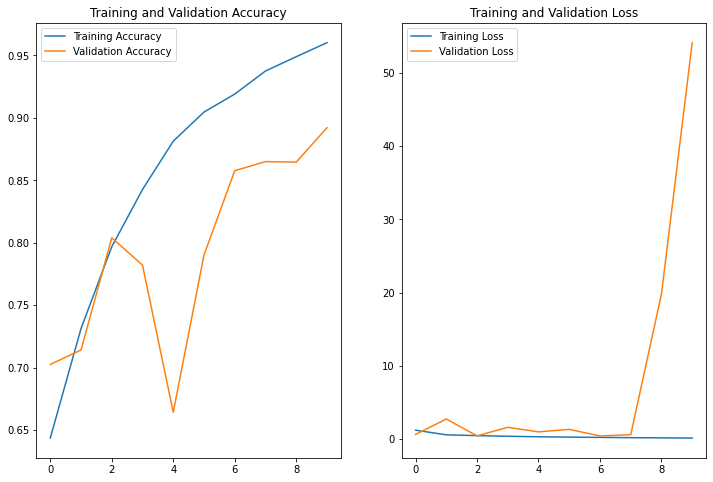

In [57]:
history = history_34
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [59]:
# 이..이게 무슨일이당가 resnet_34는 과적합이 되어버렸다....
val_loss

[0.5982205867767334,
 2.715400218963623,
 0.41005584597587585,
 1.5776422023773193,
 0.9572268724441528,
 1.2949683666229248,
 0.3972538411617279,
 0.56667560338974,
 19.807096481323242,
 54.145118713378906]

In [60]:
resnet_50.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [61]:
history_50 = resnet_50.fit(train_batches,
                    epochs=epoch,
                    validation_data=validation_batches)

Epoch 1/10
166/582 [=======>......................] - ETA: 1:14 - loss: 2.4459 - accuracy: 0.5873

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:08 - loss: 2.2481 - accuracy: 0.5953

209/582 [=========>....................] - ETA: 1:06 - loss: 2.2141 - accuracy: 0.5939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 1.9148 - accuracy: 0.6046

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 1.4562 - accuracy: 0.6255

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 1.4358 - accuracy: 0.6278

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 1.4186 - accuracy: 0.6301

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 1.3831 - accuracy: 0.6326

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 1.3764 - accuracy: 0.6329

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.3331 - accuracy: 0.6367

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 111s 182ms/step - loss: 1.3331 - accuracy: 0.6367 - val_loss: 0.6012 - val_accuracy: 0.7029
Epoch 2/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.6255 - accuracy: 0.7103

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.6197 - accuracy: 0.7134

209/582 [=========>....................] - ETA: 1:05 - loss: 0.6234 - accuracy: 0.7119

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.6162 - accuracy: 0.7121

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.5890 - accuracy: 0.7220

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.5896 - accuracy: 0.7216

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.5878 - accuracy: 0.7226

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.5851 - accuracy: 0.7234

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.5843 - accuracy: 0.7235

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.7241

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.5815 - accuracy: 0.7241 - val_loss: 0.5691 - val_accuracy: 0.7089
Epoch 3/10
167/582 [=======>......................] - ETA: 1:13 - loss: 0.4993 - accuracy: 0.7708

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.5017 - accuracy: 0.7709

209/582 [=========>....................] - ETA: 1:05 - loss: 0.5057 - accuracy: 0.7691

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.4969 - accuracy: 0.7724

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.4781 - accuracy: 0.7812

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.4759 - accuracy: 0.7822

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.4750 - accuracy: 0.7832

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.4730 - accuracy: 0.7851

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.4723 - accuracy: 0.7853

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.7862

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 180ms/step - loss: 0.4707 - accuracy: 0.7862 - val_loss: 8079.4814 - val_accuracy: 0.7120
Epoch 4/10
167/582 [=======>......................] - ETA: 1:13 - loss: 0.4158 - accuracy: 0.8204

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.4146 - accuracy: 0.8196

209/582 [=========>....................] - ETA: 1:05 - loss: 0.4163 - accuracy: 0.8180

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 0.4035 - accuracy: 0.8218

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.3913 - accuracy: 0.8285

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.3902 - accuracy: 0.8289

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.3880 - accuracy: 0.8300

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.3856 - accuracy: 0.8310

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.3856 - accuracy: 0.8310

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.8315

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 181ms/step - loss: 0.3846 - accuracy: 0.8315 - val_loss: 0.4048 - val_accuracy: 0.8156
Epoch 5/10
166/582 [=======>......................] - ETA: 1:12 - loss: 0.3448 - accuracy: 0.8503

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.3398 - accuracy: 0.8544

209/582 [=========>....................] - ETA: 1:05 - loss: 0.3387 - accuracy: 0.8559

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.3368 - accuracy: 0.8563

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.3228 - accuracy: 0.8623

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.3210 - accuracy: 0.8634

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.3206 - accuracy: 0.8632

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.3164 - accuracy: 0.8651

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.3157 - accuracy: 0.8653

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8661

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.3133 - accuracy: 0.8661 - val_loss: 1100.5826 - val_accuracy: 0.7248
Epoch 6/10
167/582 [=======>......................] - ETA: 1:13 - loss: 0.2834 - accuracy: 0.8829

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.2764 - accuracy: 0.8846

209/582 [=========>....................] - ETA: 1:05 - loss: 0.2779 - accuracy: 0.8841

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.2709 - accuracy: 0.8870

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.2593 - accuracy: 0.8915

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.2593 - accuracy: 0.8914

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.2597 - accuracy: 0.8914

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.2561 - accuracy: 0.8931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.2554 - accuracy: 0.8934

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.8932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.2545 - accuracy: 0.8932 - val_loss: 2.1251 - val_accuracy: 0.8547
Epoch 7/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.2194 - accuracy: 0.9087

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.2172 - accuracy: 0.9095

209/582 [=========>....................] - ETA: 1:05 - loss: 0.2178 - accuracy: 0.9094

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.2116 - accuracy: 0.9129

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.2046 - accuracy: 0.9164

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.2052 - accuracy: 0.9165

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.2049 - accuracy: 0.9166

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.2035 - accuracy: 0.9171

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.2026 - accuracy: 0.9174

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9189

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 180ms/step - loss: 0.1990 - accuracy: 0.9189 - val_loss: 303.0157 - val_accuracy: 0.7051
Epoch 8/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.1685 - accuracy: 0.9332

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.1643 - accuracy: 0.9353

209/582 [=========>....................] - ETA: 1:05 - loss: 0.1689 - accuracy: 0.9341

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.1654 - accuracy: 0.9359

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.1588 - accuracy: 0.9372

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.1581 - accuracy: 0.9376

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.1579 - accuracy: 0.9374

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.1543 - accuracy: 0.9391

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.1540 - accuracy: 0.9392

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9395

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 180ms/step - loss: 0.1525 - accuracy: 0.9395 - val_loss: 4494.0527 - val_accuracy: 0.8246
Epoch 9/10
166/582 [=======>......................] - ETA: 1:12 - loss: 0.1311 - accuracy: 0.9495

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.1301 - accuracy: 0.9491

209/582 [=========>....................] - ETA: 1:05 - loss: 0.1293 - accuracy: 0.9492

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.1257 - accuracy: 0.9515

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.1274 - accuracy: 0.9519

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.1268 - accuracy: 0.9523

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.1257 - accuracy: 0.9528

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.1239 - accuracy: 0.9535

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.1241 - accuracy: 0.9532

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9531

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.1244 - accuracy: 0.9531 - val_loss: 102.2526 - val_accuracy: 0.8629
Epoch 10/10
167/582 [=======>......................] - ETA: 1:12 - loss: 0.0939 - accuracy: 0.9639

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.0911 - accuracy: 0.9645

209/582 [=========>....................] - ETA: 1:05 - loss: 0.0923 - accuracy: 0.9640

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.0933 - accuracy: 0.9634

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.1004 - accuracy: 0.9618

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.0993 - accuracy: 0.9623

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.0990 - accuracy: 0.9624

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.0986 - accuracy: 0.9624

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.0983 - accuracy: 0.9625

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9630

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 180ms/step - loss: 0.0973 - accuracy: 0.9630 - val_loss: 994.8144 - val_accuracy: 0.8633


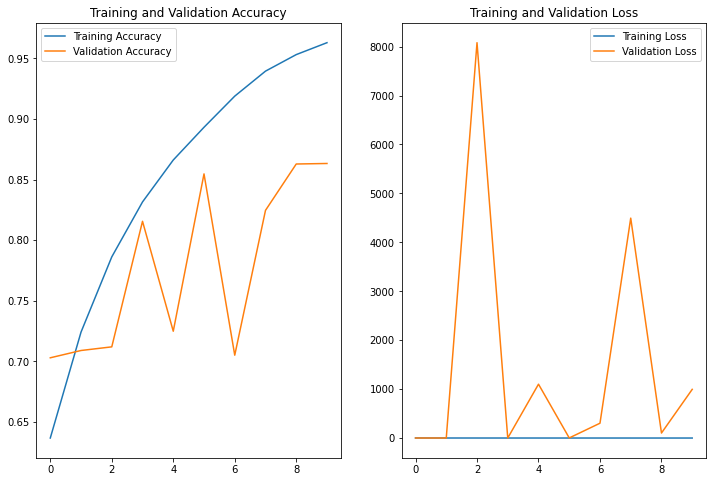

In [62]:
history = history_50
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [64]:
plain_34.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
history_p34 = plain_34.fit(train_batches,
                    epochs=epoch,
                    validation_data=validation_batches)

Epoch 1/10
167/582 [=======>......................] - ETA: 1:14 - loss: 2.4838 - accuracy: 0.5908

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:08 - loss: 2.3152 - accuracy: 0.5911

209/582 [=========>....................] - ETA: 1:06 - loss: 2.2708 - accuracy: 0.5891

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 1.9904 - accuracy: 0.5958

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 1.4932 - accuracy: 0.6236

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 1.4761 - accuracy: 0.6235

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 1.4594 - accuracy: 0.6243

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 1.4195 - accuracy: 0.6282

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 1.4110 - accuracy: 0.6281

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.3634 - accuracy: 0.6330

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 185ms/step - loss: 1.3634 - accuracy: 0.6330 - val_loss: 0.8867 - val_accuracy: 0.5813
Epoch 2/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.6039 - accuracy: 0.6971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.5959 - accuracy: 0.6999

209/582 [=========>....................] - ETA: 1:05 - loss: 0.5926 - accuracy: 0.7007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.5848 - accuracy: 0.7048

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.5576 - accuracy: 0.7232

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.5566 - accuracy: 0.7237

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.5556 - accuracy: 0.7245

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.5504 - accuracy: 0.7285

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.5492 - accuracy: 0.7296

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.7323

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.5460 - accuracy: 0.7323 - val_loss: 0.5600 - val_accuracy: 0.7261
Epoch 3/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.4808 - accuracy: 0.7762

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.4790 - accuracy: 0.7784

209/582 [=========>....................] - ETA: 1:06 - loss: 0.4778 - accuracy: 0.7792

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 53s - loss: 0.4673 - accuracy: 0.7834

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.4461 - accuracy: 0.7963

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.4440 - accuracy: 0.7971

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.4423 - accuracy: 0.7981

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.4409 - accuracy: 0.7987

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.4399 - accuracy: 0.7990

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.7994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 185ms/step - loss: 0.4383 - accuracy: 0.7994 - val_loss: 0.4145 - val_accuracy: 0.8181
Epoch 4/10
166/582 [=======>......................] - ETA: 1:13 - loss: 0.3801 - accuracy: 0.8357

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 1:07 - loss: 0.3768 - accuracy: 0.8364

209/582 [=========>....................] - ETA: 1:05 - loss: 0.3792 - accuracy: 0.8360

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 52s - loss: 0.3670 - accuracy: 0.8402

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 16s - loss: 0.3568 - accuracy: 0.8478

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 14s - loss: 0.3561 - accuracy: 0.8480

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 12s - loss: 0.3552 - accuracy: 0.8483

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 7s - loss: 0.3540 - accuracy: 0.8492

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 6s - loss: 0.3538 - accuracy: 0.8493

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8496

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 180ms/step - loss: 0.3517 - accuracy: 0.8496 - val_loss: 0.4252 - val_accuracy: 0.8289
Epoch 5/10
 15/582 [..............................] - ETA: 1:39 - loss: 0.3197 - accuracy: 0.8521

In [ ]:
history = history_p34
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


train plain_50

In [ ]:
plain_50.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
history_p50 = plain_50.fit(train_batches,
                    epochs=epoch,
                    validation_data=validation_batches)

In [ ]:
history = history_p50
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
def get_predict_vis(Model, test_batches):
    for image_batch, label_batch in test_batches.take(1):
        images = image_batch
        labels = label_batch
        predictions = Model.predict(image_batch)
        pass
    
    predictions = np.argmax(predictions, axis=1)

    plt.figure(figsize=(20,12))

    for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        plt.subplot(4, 8, idx+1)
        image = (image + 1) / 2 # make image positive
        plt.imshow(image)
        correct = label == prediction
        title = f'real:{label} / pred :{prediction}\n {correct}!'
        if not correct:
            plt.title(title, fontdict={'color':'red'})
        else:
            plt.title(title,fontdict={'color':'blue'})
            plt.axis('off')
    return predictions

In [ ]:
predictions_34 = get_predict_vis(resnet_34, test_batches)

dog & cat dataset을 다시 다운받으면서 Corrupt files 에러를 해결해야할 것 같다.

epochs를 더 늘리거나 전처리를 다르게 해서 과적합을 줄여야할 것 같다..